In [1]:
import yaml
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scatseisnet import ScatteringNetwork
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
plt.style.use('ggplot')

In [2]:
path = '/Volumes/Projects2023'
files = os.listdir(path)
sites = []

for file in files:
    if file.endswith('.h5'):
        dir=os.path.join(path,file)
        f = h5py.File(dir, 'r')
        sites.append(pd.DataFrame(list(f.keys()), columns=[file]))

df = pd.concat(sites, axis=1)

df

,ev0000364000.h5,ev0000734973.h5,ev0000447288.h5,ev0000593283.h5,ev0000773200.h5,ev0001903830.h5,ev0002128689.h5
0,IWEH,AIOH,IWZH,AIRH,BTOH,CHKH,AKIH
1,KI2H,AKSH,KANH,AKIH,DGOH,FGTH,AS2H
2,MKJH,AMNH,KASH,AKNH,FKSH,FKSH,ASKH
3,NMEH,AYKH,KJNH,ASKH,GZNH,FSWH,BZNH
4,NaN,BSEH,KJSH,BZNH,HTAH,HMNH,GKSH
...,...,...,...,...,...,...,...
70,NaN,NaN,NaN,UWEH,NaN,NaN,NaN
71,NaN,NaN,NaN,WKMH,NaN,NaN,NaN
72,NaN,NaN,NaN,YABH,NaN,NaN,NaN
73,NaN,NaN,NaN,YGNH,NaN,NaN,NaN


In [3]:
# 统计每个站点在所有文件中出现的次数
counts = df.stack().value_counts()
counts

MKJH    3
NMEH    3
HYGH    2
MRUH    2
KWMH    2
       ..
SBSH    1
IWWH    1
NKWH    1
HIYH    1
TKHH    1
Length: 235, dtype: int64

In [4]:
target_site = 'NMEH'

# 找到包含'NMEH'站点的h5文件
files_with_target = df.columns[df.isin([target_site]).any()].tolist()
event_times=[]
# 读取包含'NMEH'站点的h5文件
for file in files_with_target:
    dir=os.path.join(path,file)
    f = h5py.File(dir, 'r')
   
    data = f[target_site] # 取出NMEH站点的数据
    event_times.append(f.attrs['time']) # 取出时间
    # 此时你可以处理数据，比如打印出来，或者保存到其他地方等
    print(dir,data.shape,f.attrs['time'])

/Volumes/Projects2023/ev0000364000.h5 (3, 270000000) 2014-07-11T19:22:00.440000Z
/Volumes/Projects2023/ev0000773200.h5 (3, 270000000) 2016-11-21T20:59:46.890000Z
/Volumes/Projects2023/ev0001903830.h5 (3, 270000000) 2021-03-20T09:09:44.830000Z


In [5]:
event_times

['2014-07-11T19:22:00.440000Z',
 '2016-11-21T20:59:46.890000Z',
 '2021-03-20T09:09:44.830000Z']

In [6]:
start_hour = 726
end_hour= 750

# Number of channels
n_channels = 3
n_stations = 1
# Convert hours to sample indices
start_index = int(start_hour * 3600 * 100)
end_index = int(end_hour * 3600 * 100)

# Initialize the data array with an additional dimension for the distance
data = np.empty((len(files_with_target), n_stations, n_channels, end_index - start_index))

In [7]:
i=0
for file in files_with_target:
    dir=os.path.join(path,file)
    f = h5py.File(dir, 'r')
    data[i,0,:,:] = f[target_site][:,start_index:end_index] # data[i,,,]是第i次地震的数据
    i=i+1

In [8]:
data.shape

(3, 1, 3, 8640000)

保存的`data.npy`文件为一个`[n_events, n_stations, n_channels, n_samples]`的`np.ndarray`
+ `n_events`是地震事件的数量
+ `n_stations`是站台的数量(我们每次选1个站点进行分析)
+ `n_channels`是通道的数量
+ `n_samples`是每个通道的采样点数量

## 信号探索

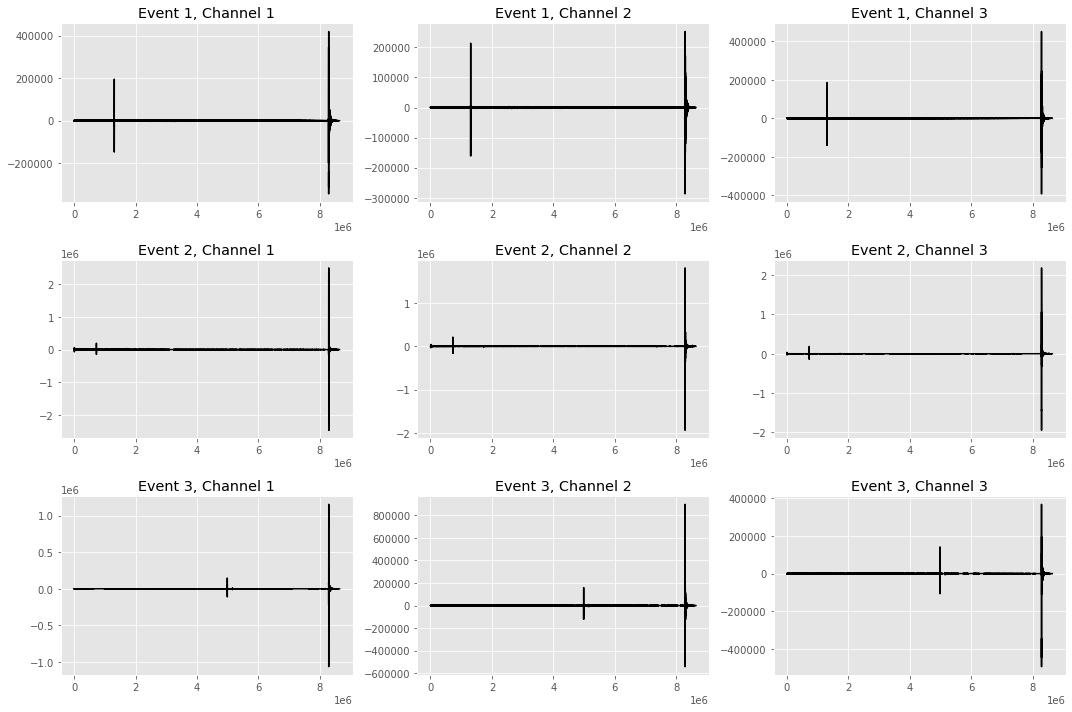

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

for i in range(3): # 遍历3次地震
    for j in range(3): # 遍历3个通道
        _=ax[i, j].plot(data[i, 0, j, :], 'k-');
        _=ax[i, j].set_title(f'Event {i+1}, Channel {j+1}');

plt.tight_layout()
plt.show();

## 网络结构

In [10]:
## 参数
segment_duration_seconds = 60.0
sampling_rate_hertz = 100.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)

ScatteringNetwork(bins=6000, sampling_rate=100.0, len=2)
ComplexMorletBank(bins=6000, octaves=4, resolution=4, quality=1, sampling_rate=100.0, len=16)
ComplexMorletBank(bins=6000, octaves=5, resolution=2, quality=3, sampling_rate=100.0, len=10)


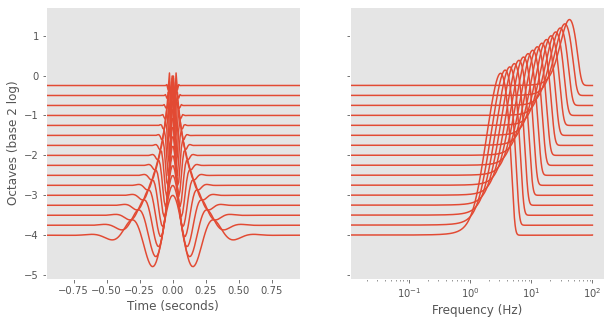

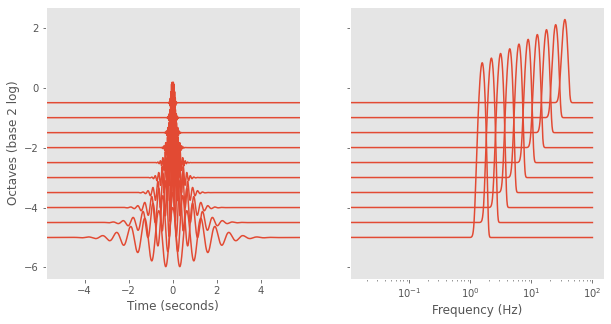

In [11]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

# 绘图
for bank in network.banks:
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    for wavelet, spectrum, ratio in zip(bank.wavelets, bank.spectra, bank.ratios):
        _=ax[0].plot(bank.times, wavelet.real + ratio, "C0")
        _=ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    width_max = 3 * bank.widths.max()
    _=ax[0].set_ylabel("Octaves (base 2 log)")
    _=ax[0].set_xlabel("Time (seconds)")
    _=ax[0].set_xlim(-width_max, width_max)
    _=ax[0].grid()
    _=ax[1].set_xscale("log")
    _=ax[1].set_xlabel("Frequency (Hz)")
    _=ax[1].grid()

plt.show()

In [12]:
from matplotlib import dates as mdates
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from obspy import Stream, Trace

In [13]:
n_events, n_stations, n_channels, n_samples = data.shape

# 选择要处理的站点的索引
station_index = 0

channel_names = ["E", "N", "Z"]  ## 三个方向的地震波的运动，这些方向分别是东(E)、北(N)和垂直向下(Z)

streams = [] # 创建一个空列表，用于保存所有的Stream对象

# 遍历所有事件、站点和通道
for event_index in range(n_events):
    stream = Stream()
    for channel_index in range(n_channels):
        # 获取数据并创建Trace对象
        trace_data = data[event_index, station_index, channel_index, :]
        trace = Trace(data=trace_data)

        # 设置Trace的元数据
        trace.stats.network = "Hi-Net"
        trace.stats.station = target_site
        trace.stats.channel = channel_names[channel_index]
        trace.stats.sampling_rate = 100.0  
        trace.stats.starttime = UTCDateTime(event_times[event_index])

        # 将Trace对象添加到Stream中
        stream += trace
    
    streams.append(stream) # 将当前的Stream对象添加到列表中

# 现在，你可以通过索引访问streams列表中的每个Stream对象，例如：
print(streams[0]) # 打印第一个事件的Stream对象

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples


In [14]:
streams[1]

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples

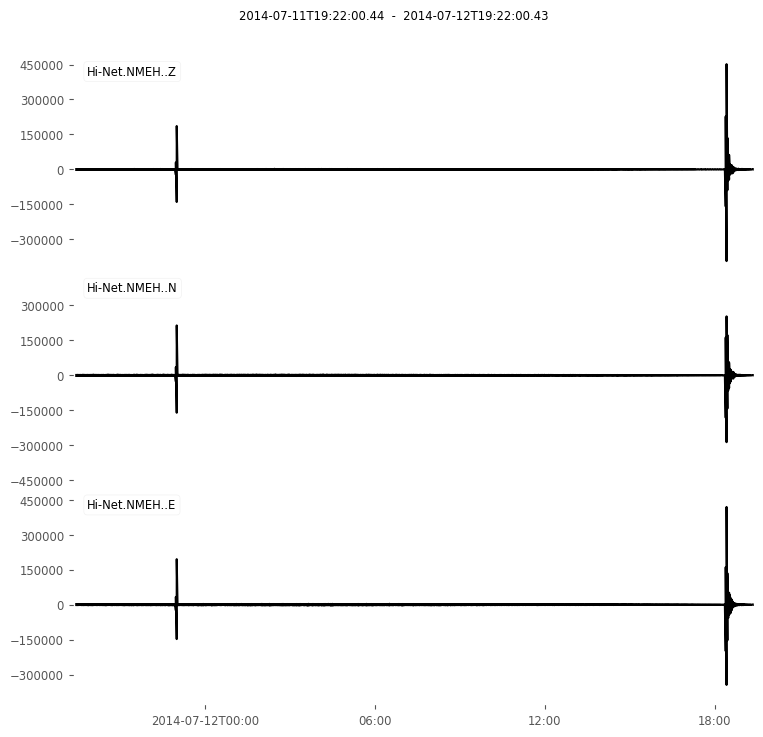

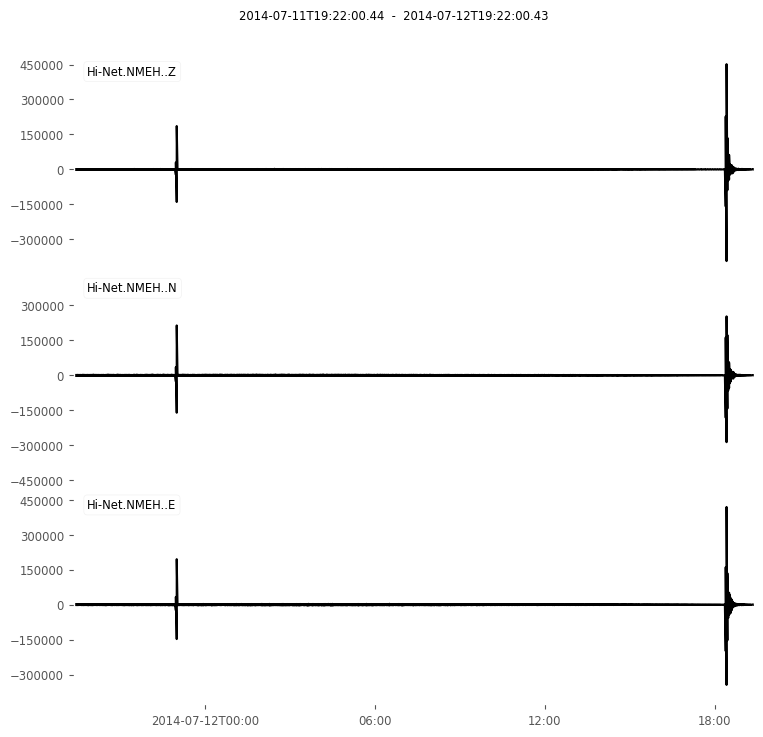

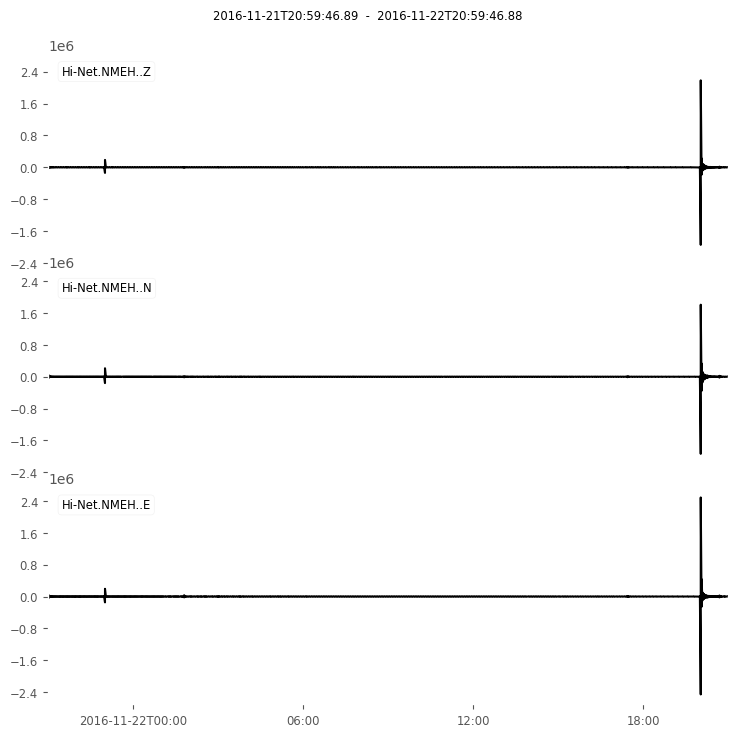

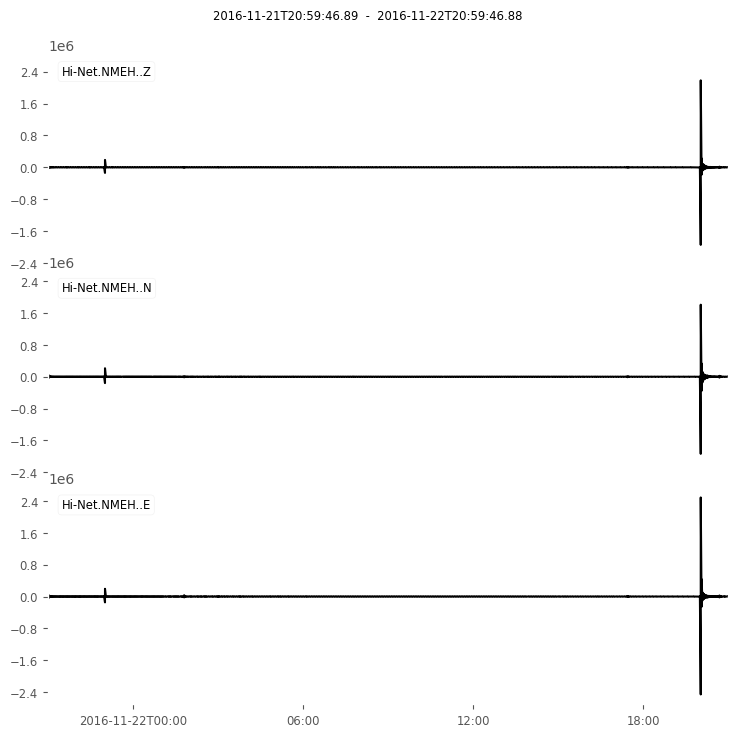

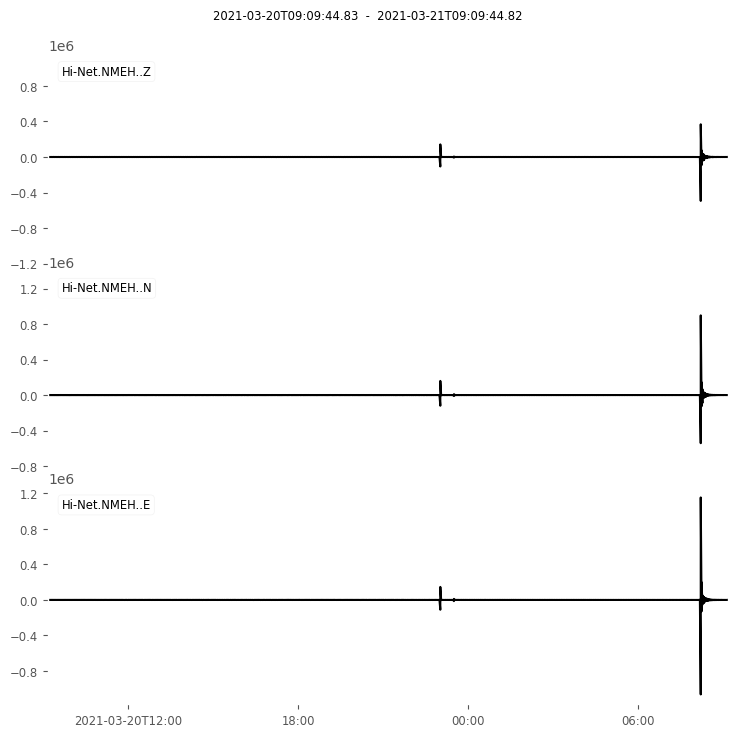

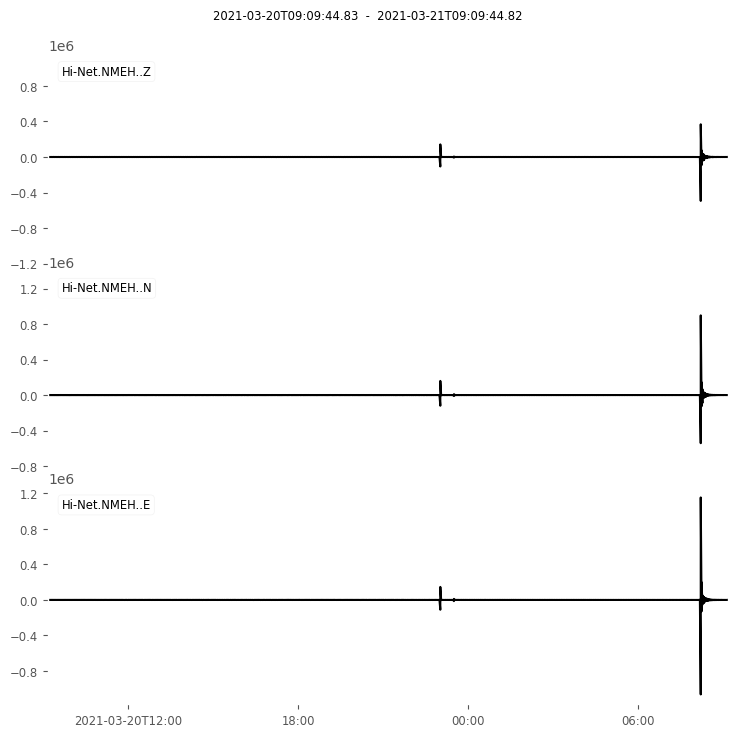

In [15]:
for i in range(len(streams)):
    streams[i].plot()

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples

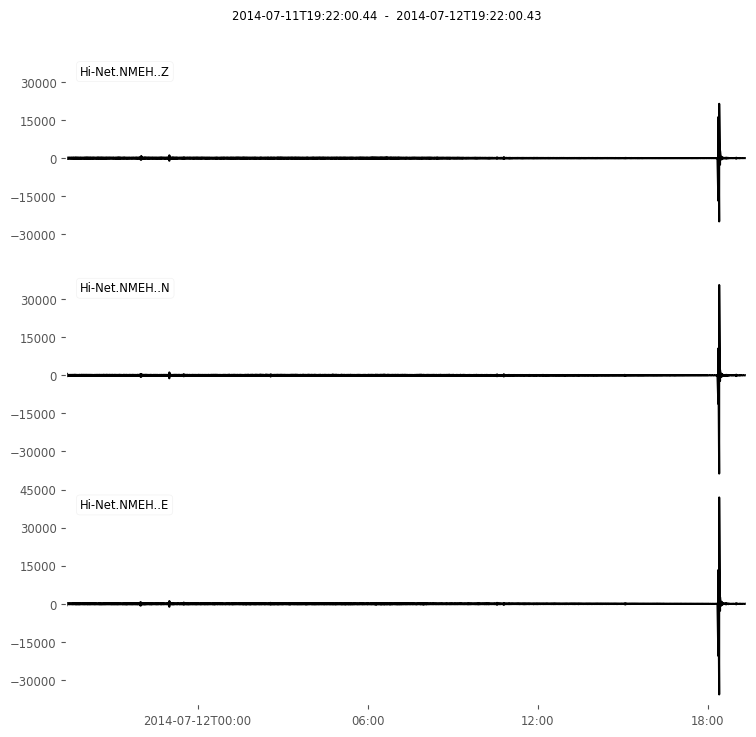

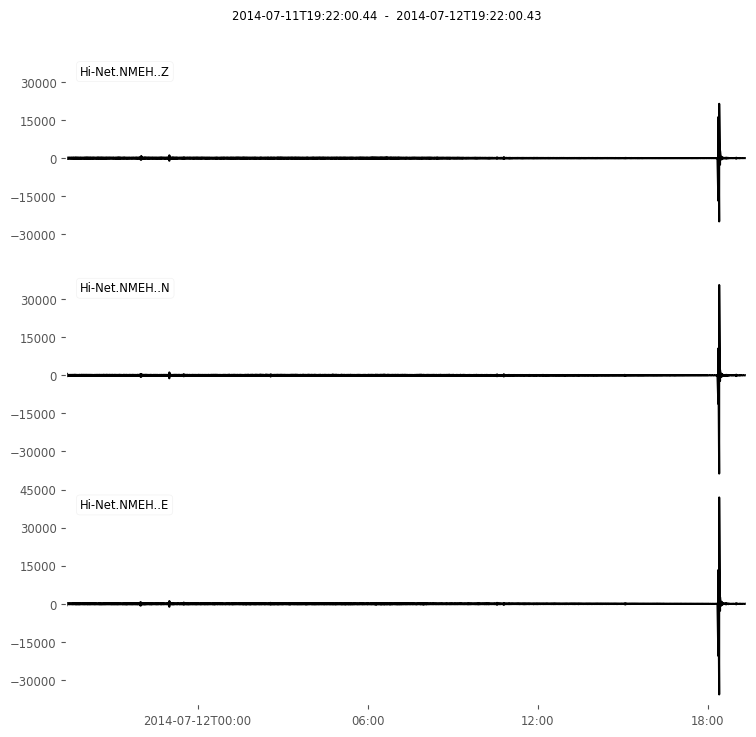

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2016-11-21T20:59:46.890000Z - 2016-11-22T20:59:46.880000Z | 100.0 Hz, 8640000 samples

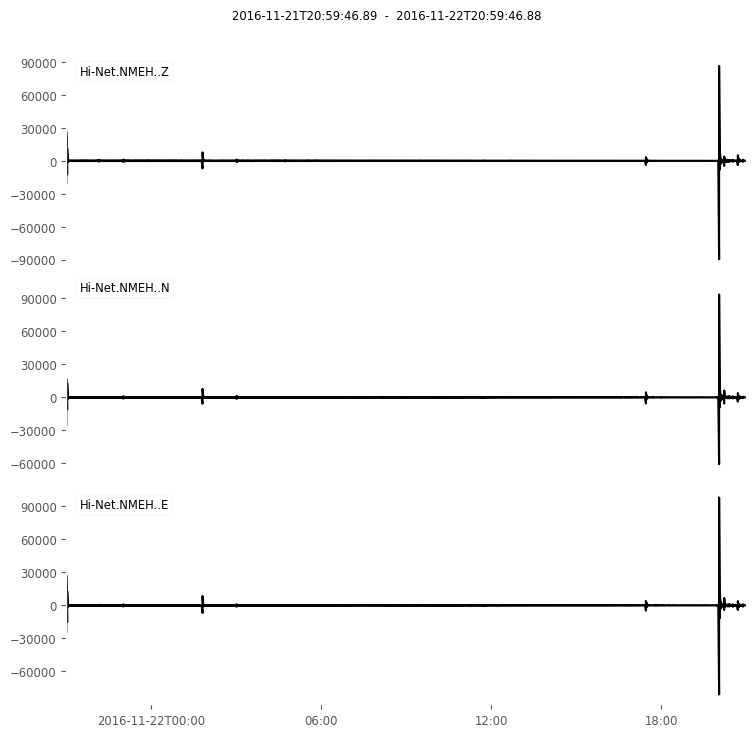

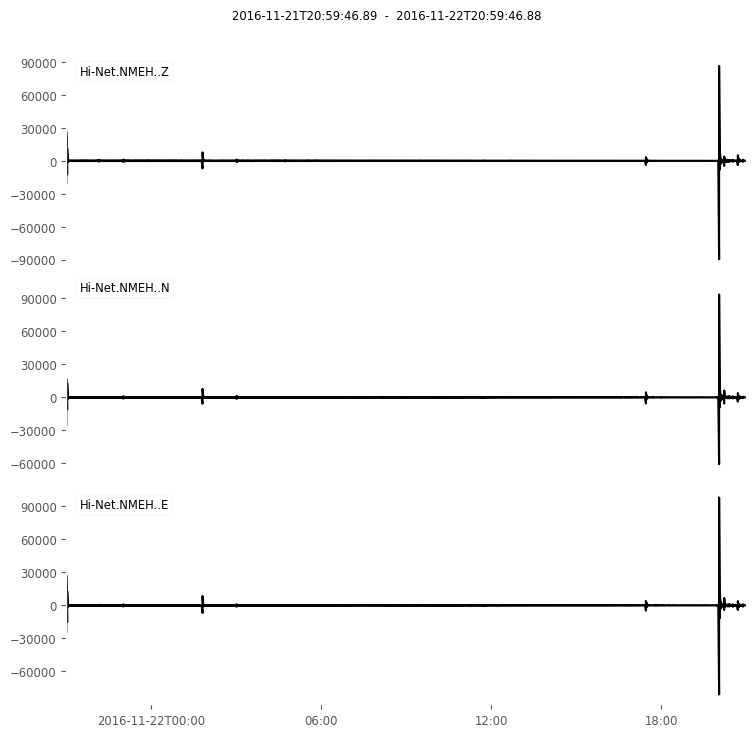

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2021-03-20T09:09:44.830000Z - 2021-03-21T09:09:44.820000Z | 100.0 Hz, 8640000 samples

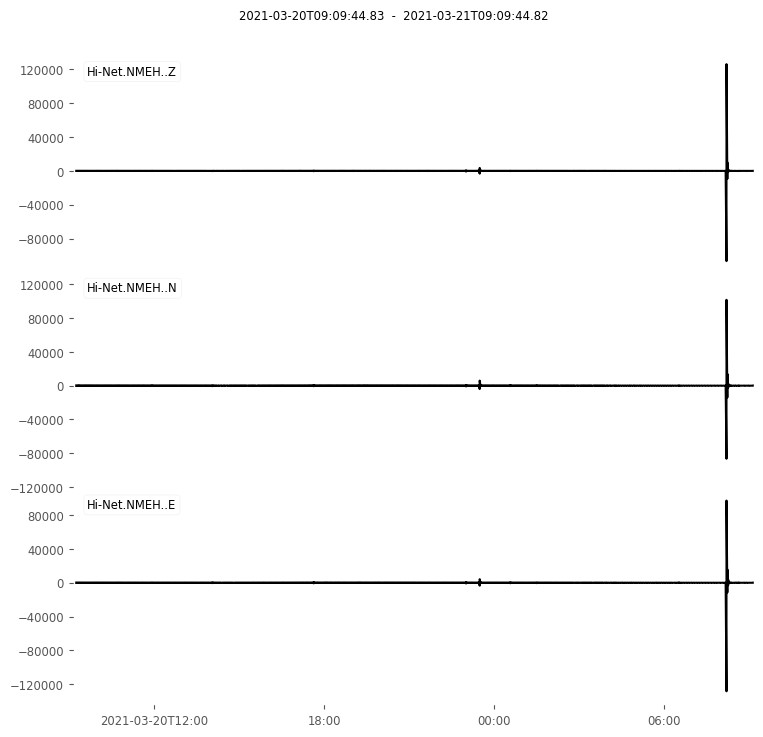

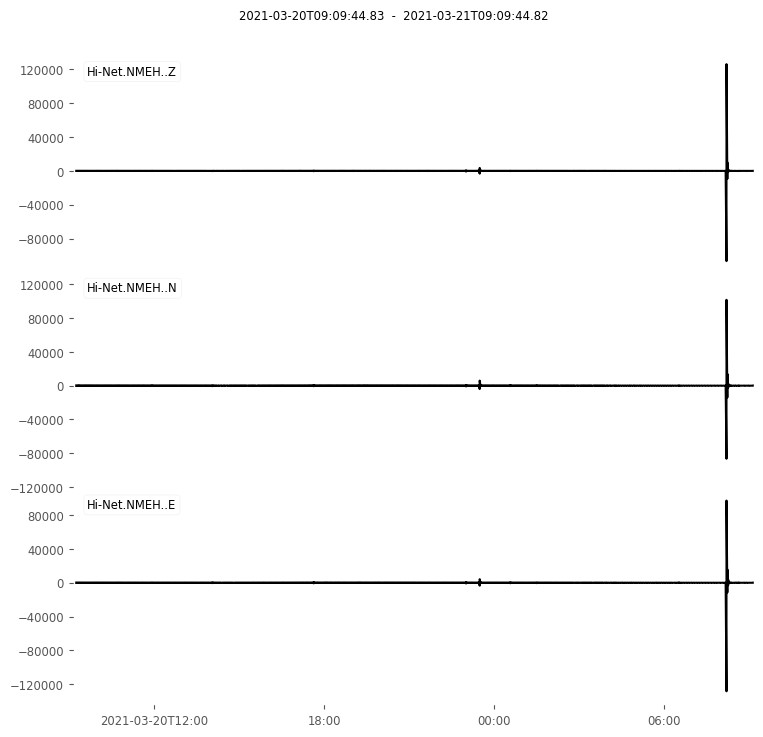

In [16]:
for i in range(3):
    streams[i].merge(method=1)
    streams[i].detrend("linear")
    #stream1=stream.copy()
    streams[i].filter(type="highpass", freq=1)
    streams[i].plot(rasterized=True)

## 每个地震(event 分开分析)

### event1

In [17]:
streams[0]

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-11T19:22:00.440000Z - 2014-07-12T19:22:00.430000Z | 100.0 Hz, 8640000 samples

In [18]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()


stream = streams[0]
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

if segments[-1].shape != segments[-2].shape:
    padding = np.zeros((segments[-1].shape[0], segments[-2].shape[1] - segments[-1].shape[1]))
    segments[-1] = np.concatenate([segments[-1], padding], axis=1)

a=np.array(segments)
a.shape

(2879, 3, 6000)

In [19]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

In [20]:
sca0=scattering_coefficients.copy() 

In [21]:
scattering_coefficients

[array([[[3.51938528e+02, 3.79341709e+02, 4.22814505e+02, ...,
          2.56936880e+03, 3.10966116e+03, 3.78945169e+03],
         [5.32282222e+02, 5.73606942e+02, 6.39173617e+02, ...,
          3.75971808e+03, 4.48062607e+03, 5.34105203e+03],
         [1.12233867e+02, 1.21101248e+02, 1.35217468e+02, ...,
          1.03243580e+03, 1.33904702e+03, 1.79715028e+03]],
 
        [[4.80056885e+00, 5.16252002e+00, 5.74244004e+00, ...,
          3.60166968e+01, 7.17873560e+01, 1.55153797e+02],
         [3.69359977e+01, 3.98412401e+01, 4.44797323e+01, ...,
          3.14656922e+02, 4.22272627e+02, 6.08114511e+02],
         [1.43378029e+01, 1.55325090e+01, 1.74692665e+01, ...,
          2.19742078e+02, 3.04315783e+02, 4.39732673e+02]],
 
        [[1.16540633e+01, 1.26417962e+01, 1.42332658e+01, ...,
          2.02348213e+02, 3.00391523e+02, 4.42375529e+02],
         [1.03764918e+02, 1.11881622e+02, 1.24780420e+02, ...,
          7.93613430e+02, 9.75604723e+02, 1.21623540e+03],
         [1.876865

<ipython-input-22-038f8018425e>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)


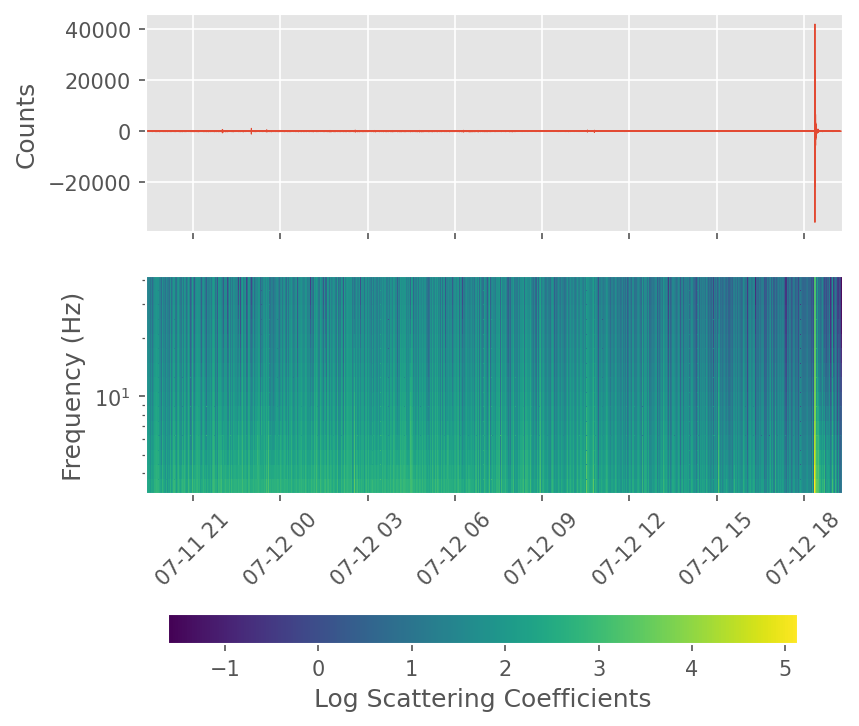

In [22]:
# 提取第一个通道
channel_id = 0
trace = streams[0][channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# 创建图形和坐标轴
fig, ax = plt.subplots(2, sharex=True, dpi=150)

# 画出波形
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# 画出一阶散射系数
cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# 坐标轴标签
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
plt.xticks(rotation=45) 

# 添加颜色条
fig.subplots_adjust(bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.05])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', label='Log Scattering Coefficients')

# 显示图形
plt.show();

In [23]:
from sklearn.decomposition import FastICA
order_1=scattering_coefficients[0]
order_2=scattering_coefficients[1]
times=timestamps

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))


Collected 2879 samples of 528 dimensions each.


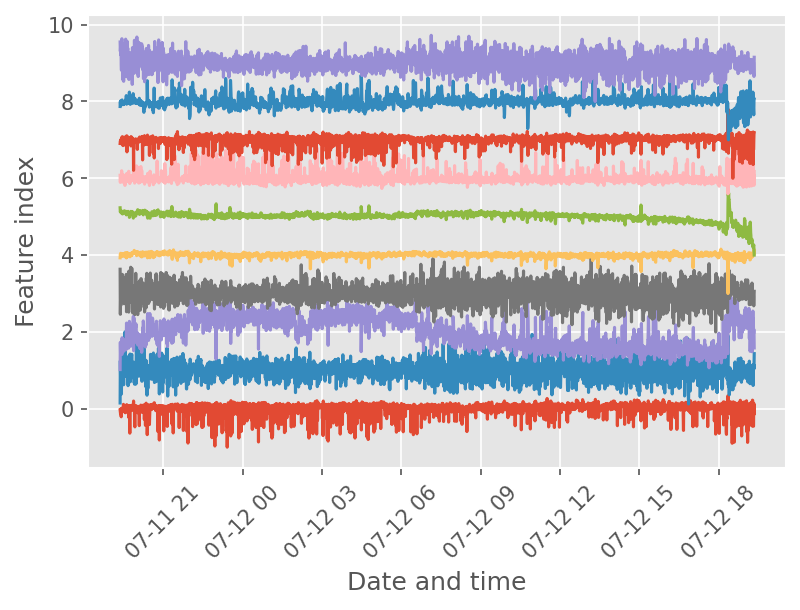

In [24]:
n_components=10
model = FastICA(n_components=n_components, whiten="unit-variance", random_state=123, max_iter=1000)
features = model.fit_transform(scattering_coefficients)
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=150)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

plt.xticks(rotation=45) 
# Show
plt.show();

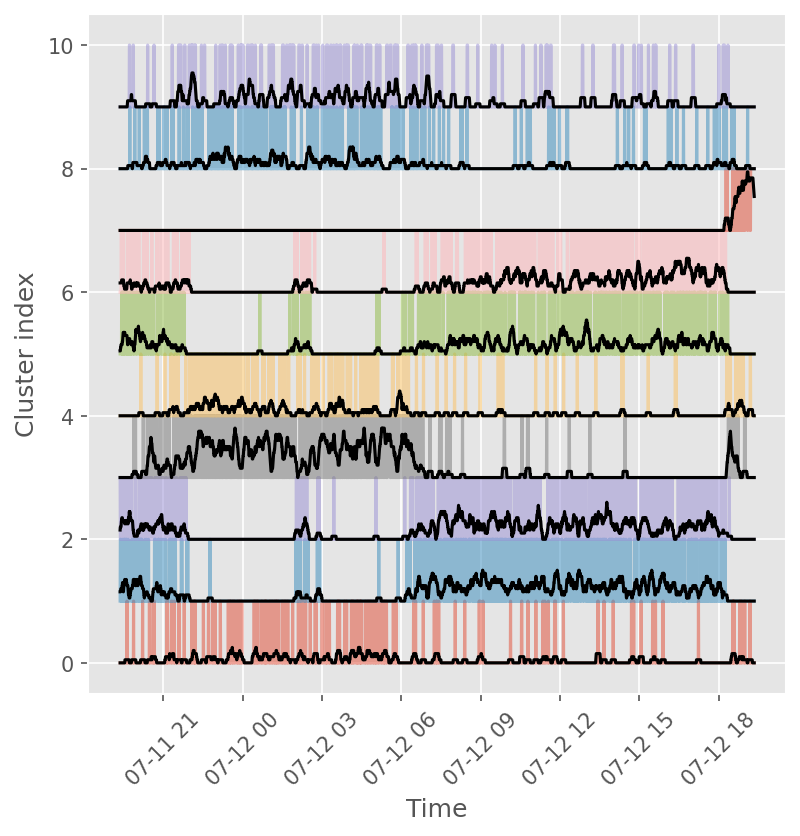

In [25]:
from scipy import signal
from sklearn.cluster import KMeans

N_CLUSTERS = 10

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=123)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")
plt.xticks(rotation=45) 
plt.show();

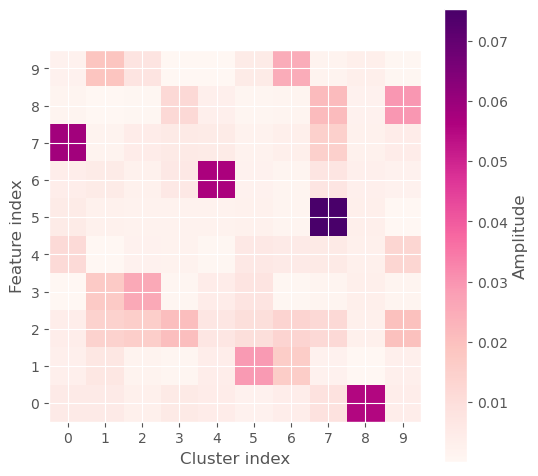

In [26]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show();

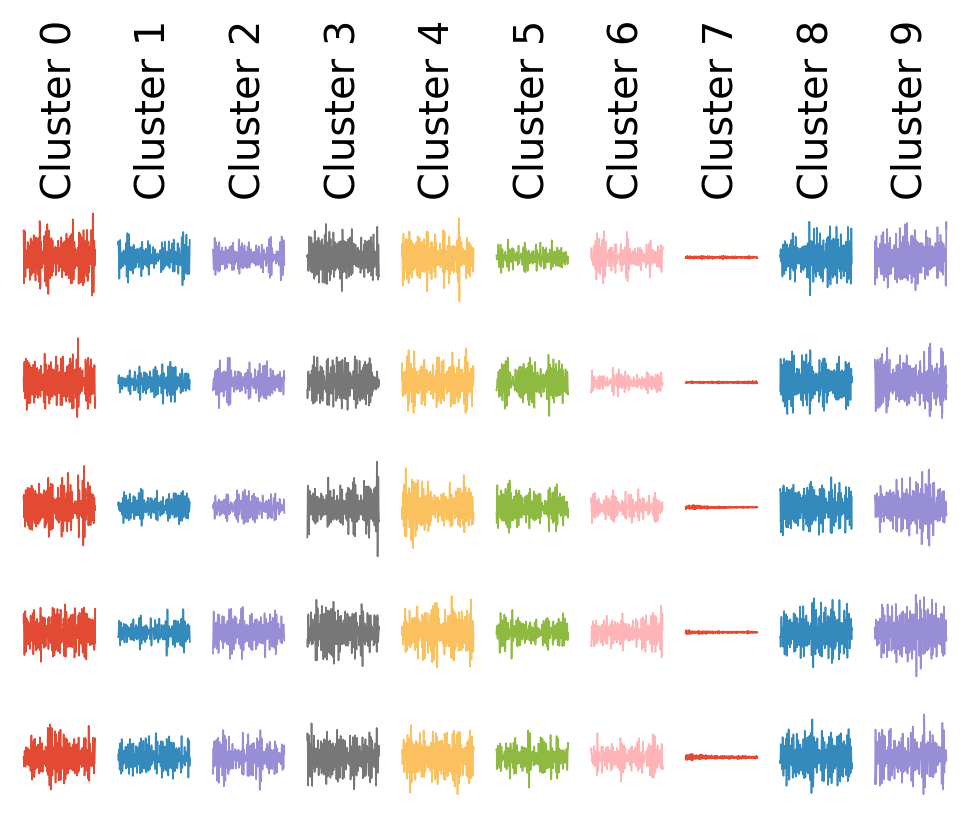

In [27]:
N_WAVEFORMS = 5

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    
    # Convert boolean array to integer indices
    indices = np.where(predictions == cluster)[0]
    closest_indices = indices[distance.argsort()[:N_WAVEFORMS]]
    closest = [times[i] for i in closest_indices]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy() 
        traces.append(trace)
    waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=200)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show();

### event2

In [28]:
timestamps = list()
segments = list()


stream = streams[1]
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

if segments[-1].shape != segments[-2].shape:
    padding = np.zeros((segments[-1].shape[0], segments[-2].shape[1] - segments[-1].shape[1]))
    segments[-1] = np.concatenate([segments[-1], padding], axis=1)

a=np.array(segments)
a.shape

(2879, 3, 6000)

In [29]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

In [30]:
sca1=scattering_coefficients.copy()

<ipython-input-31-feb20e558d8d>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)


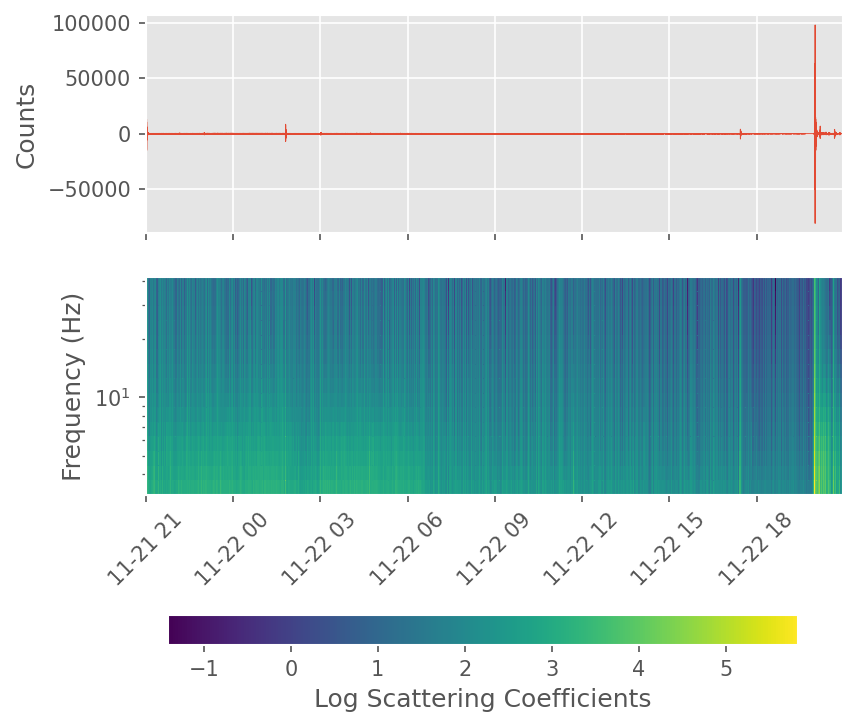

In [31]:
# 提取第一个通道
channel_id = 0
trace = streams[1][channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# 创建图形和坐标轴
fig, ax = plt.subplots(2, sharex=True, dpi=150)

# 画出波形
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# 画出一阶散射系数
cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# 坐标轴标签
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
plt.xticks(rotation=45) 

# 添加颜色条
fig.subplots_adjust(bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.05])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', label='Log Scattering Coefficients')

# 显示图形
plt.show();

In [32]:
order_1=scattering_coefficients[0]
order_2=scattering_coefficients[1]
times=timestamps

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 2879 samples of 528 dimensions each.


/Users/bubble/Anaconda3/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


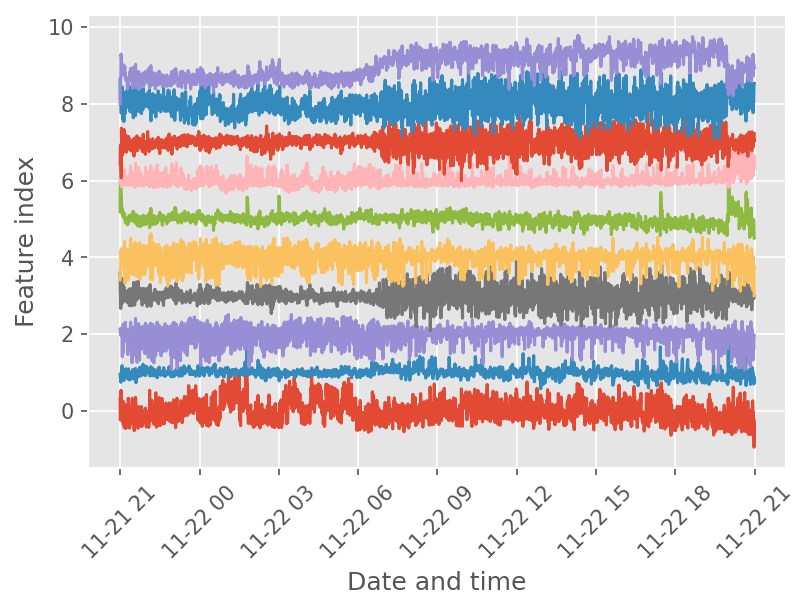

In [33]:
n_components=10
model = FastICA(n_components=n_components, whiten="unit-variance", random_state=123, max_iter=1000)
features = model.fit_transform(scattering_coefficients)

# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=150)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

plt.xticks(rotation=45) 
# Show
plt.show();

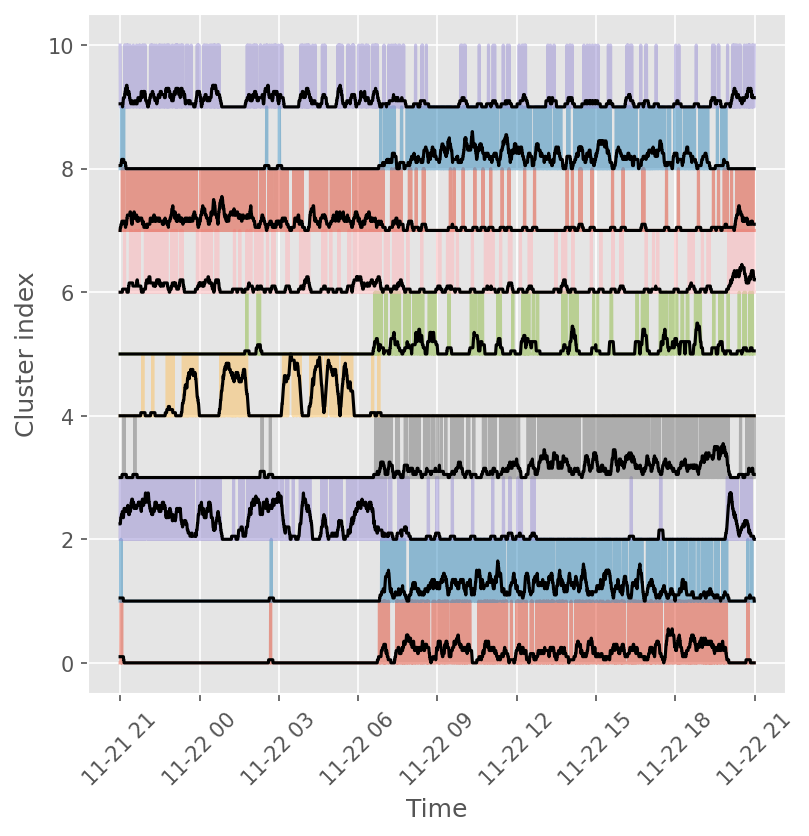

In [34]:
N_CLUSTERS = 10

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=123)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")
plt.xticks(rotation=45) 
plt.show();

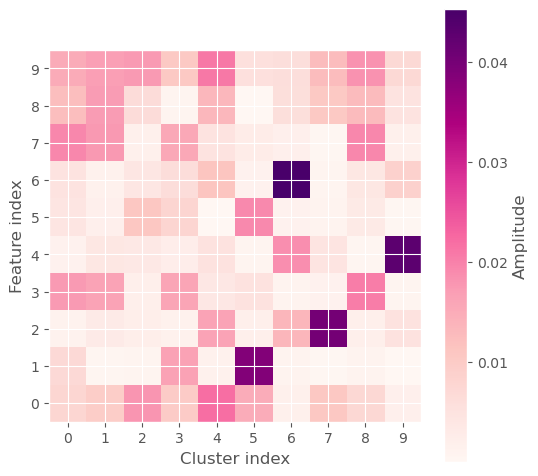

In [35]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show();

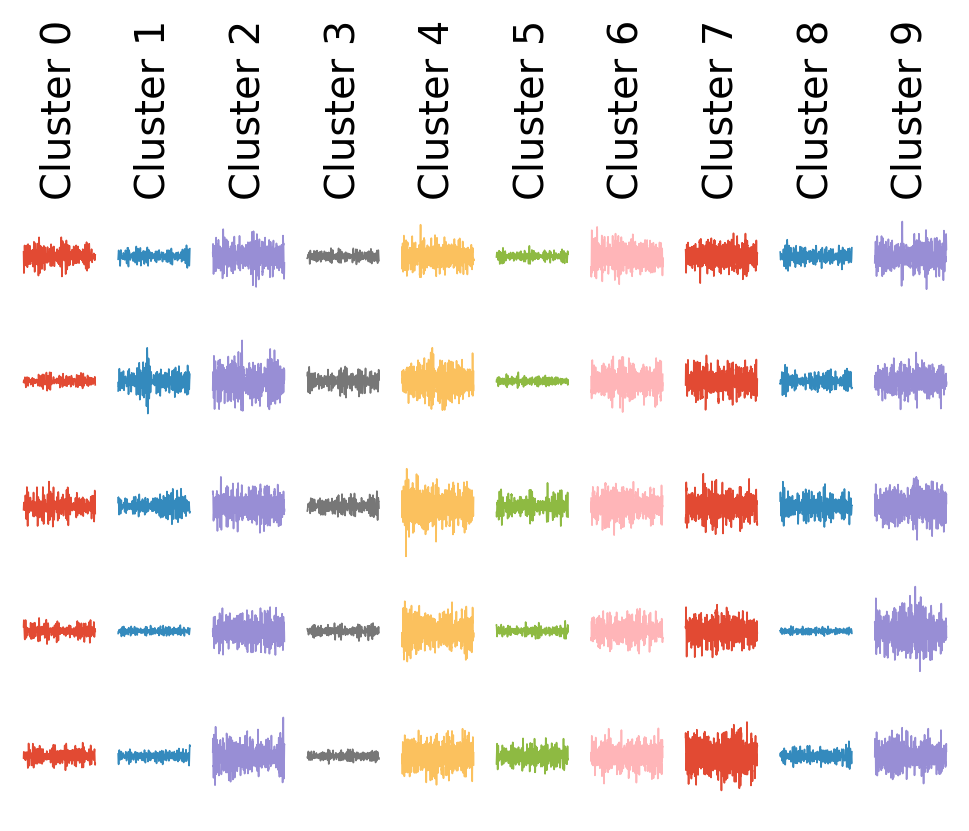

In [36]:
N_WAVEFORMS = 5

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    
    # Convert boolean array to integer indices
    indices = np.where(predictions == cluster)[0]
    closest_indices = indices[distance.argsort()[:N_WAVEFORMS]]
    closest = [times[i] for i in closest_indices]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy() 
        traces.append(trace)
    waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=200)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show();

### event 3

In [37]:
timestamps = list()
segments = list()


stream = streams[2]
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

if segments[-1].shape != segments[-2].shape:
    padding = np.zeros((segments[-1].shape[0], segments[-2].shape[1] - segments[-1].shape[1]))
    segments[-1] = np.concatenate([segments[-1], padding], axis=1)

a=np.array(segments)
a.shape

(2879, 3, 6000)

In [38]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

In [39]:
sca2=scattering_coefficients.copy()

In [40]:
scattering_coefficients=sca2

<ipython-input-41-03bbe1c47ac0>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)


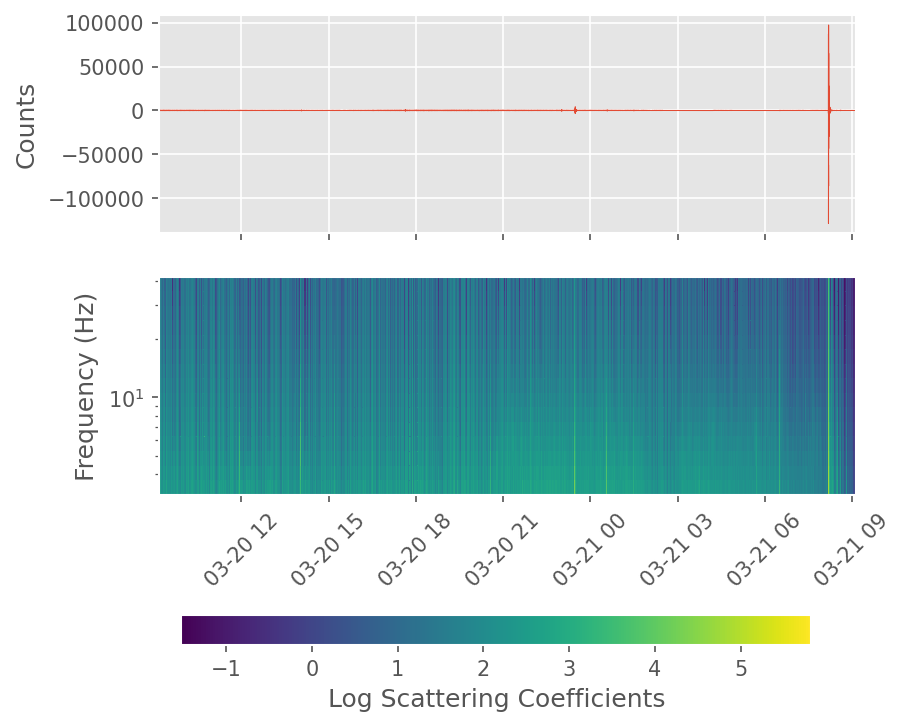

In [41]:
# 提取第一个通道
channel_id = 0
trace = streams[2][channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# 创建图形和坐标轴
fig, ax = plt.subplots(2, sharex=True, dpi=150)

# 画出波形
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# 画出一阶散射系数
cax = ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# 坐标轴标签
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")
plt.xticks(rotation=45) 

# 添加颜色条
fig.subplots_adjust(bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.15, -0.15, 0.7, 0.05])
fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', label='Log Scattering Coefficients')

# 显示图形
plt.show();

In [42]:
sca2

[array([[[2.23594403e+02, 2.40404166e+02, 2.67502076e+02, ...,
          1.57459028e+03, 1.89378820e+03, 2.28258840e+03],
         [9.58964274e+01, 1.03503879e+02, 1.15426366e+02, ...,
          6.03638717e+02, 6.70357100e+02, 7.10327533e+02],
         [7.04666654e+01, 7.57172566e+01, 8.39692656e+01, ...,
          4.75043277e+02, 5.57750087e+02, 6.51701398e+02]],
 
        [[3.38671798e+00, 4.11557768e+00, 3.26172533e+00, ...,
          1.25754872e+02, 1.93650564e+02, 2.14723002e+02],
         [7.41820361e+00, 8.11649002e+00, 9.00164088e+00, ...,
          1.63541706e+02, 2.83668531e+02, 3.38114844e+02],
         [1.27629021e+01, 1.37209497e+01, 1.52127750e+01, ...,
          1.28603578e+02, 2.14889960e+02, 3.28141602e+02]],
 
        [[6.16256307e+01, 6.64434178e+01, 7.40638695e+01, ...,
          4.59341522e+02, 5.59346039e+02, 6.99608502e+02],
         [3.66551397e+01, 3.92099882e+01, 4.33409763e+01, ...,
          2.65109807e+02, 3.22559862e+02, 4.12613632e+02],
         [4.372908

In [43]:
sca2[1].shape

(2879, 3, 16, 10)

In [44]:
order_1=scattering_coefficients[0]
order_2=scattering_coefficients[1]
times=timestamps

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 2879 samples of 528 dimensions each.


/Users/bubble/Anaconda3/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


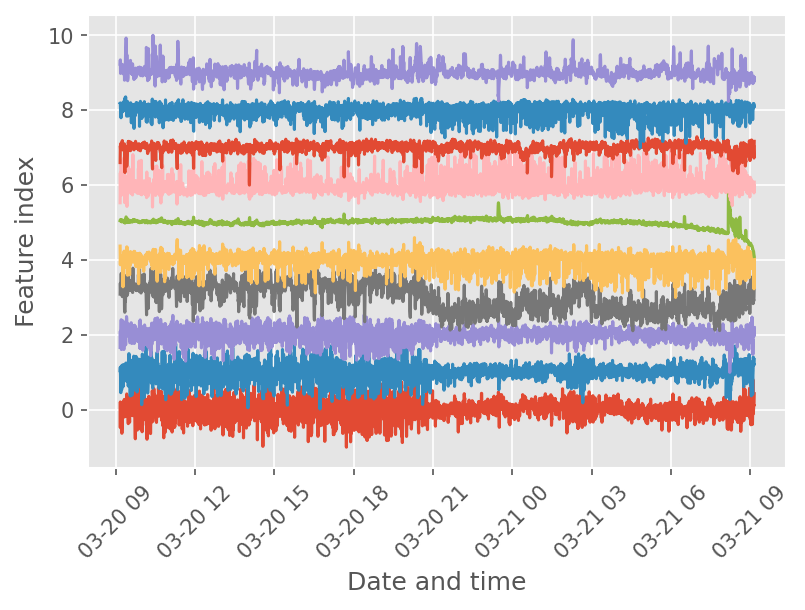

In [45]:
n_components=10
model = FastICA(n_components=n_components, whiten="unit-variance", random_state=123, max_iter=1000)
features = model.fit_transform(scattering_coefficients)

# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=150)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

plt.xticks(rotation=45) 
# Show
plt.show();

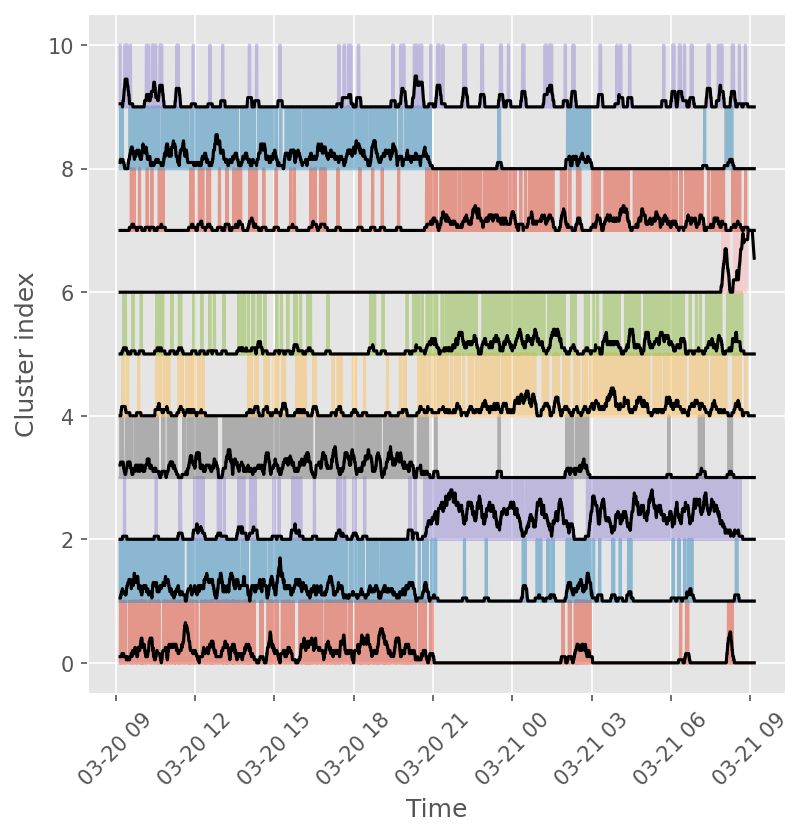

In [46]:
N_CLUSTERS = 10

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=123)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")
plt.xticks(rotation=45) 
plt.show();

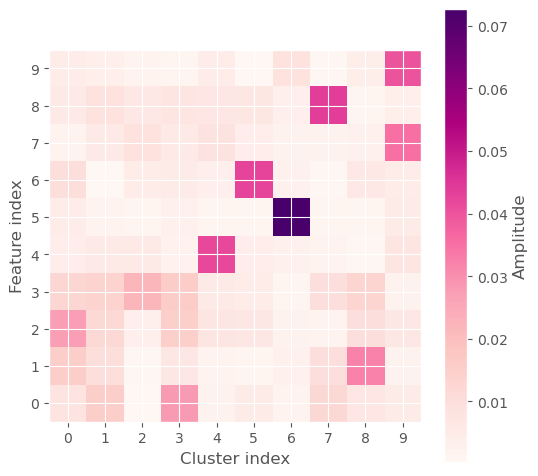

In [47]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show();

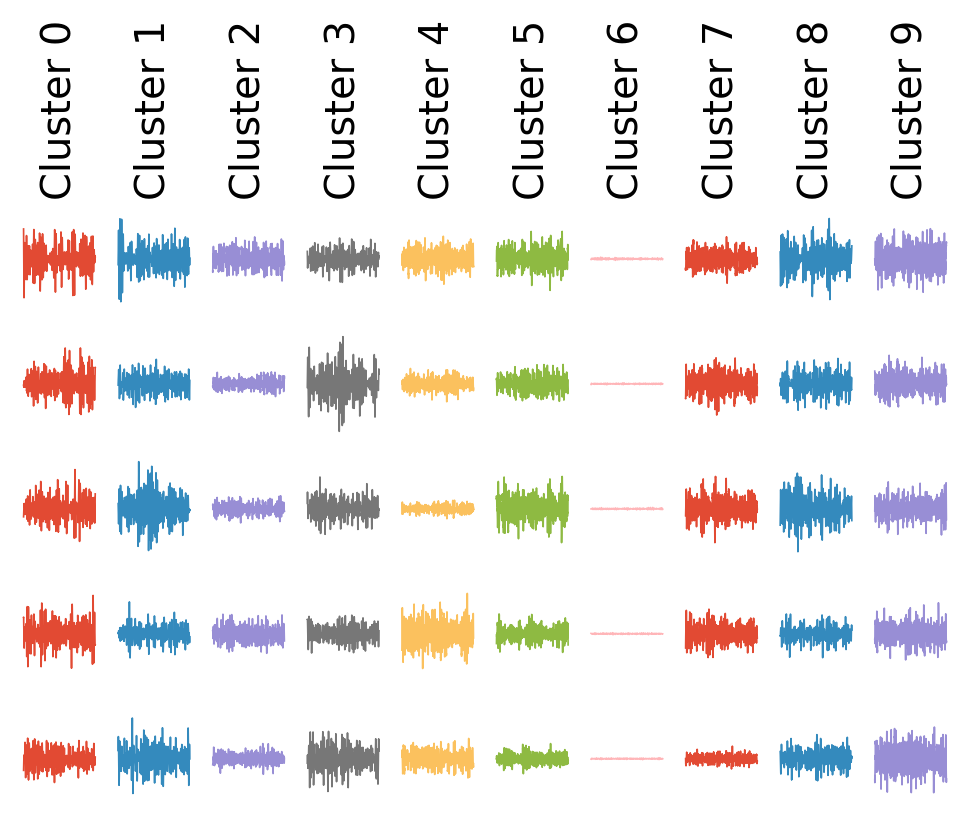

In [48]:
N_WAVEFORMS = 5

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    
    # Convert boolean array to integer indices
    indices = np.where(predictions == cluster)[0]
    closest_indices = indices[distance.argsort()[:N_WAVEFORMS]]
    closest = [times[i] for i in closest_indices]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy() 
        traces.append(trace)
    waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=200)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show();

## 三次地震一起分析

In [49]:
n_events, n_stations, n_channels, n_samples = data.shape

# 选择要处理的站点的索引
station_index = 0

channel_names = ["E", "N", "Z"]  ## 三个方向的地震波的运动，这些方向分别是东(E)、北(N)和垂直向下(Z)

streams = [] # 创建一个空列表，用于保存所有的Stream对象

# 遍历所有事件、站点和通道
for event_index in range(n_events):
    stream = Stream()
    for channel_index in range(n_channels):
        # 获取数据并创建Trace对象
        trace_data = data[event_index, station_index, channel_index, :]
        trace = Trace(data=trace_data)

        # 设置Trace的元数据
        trace.stats.network = "Hi-Net"
        trace.stats.station = target_site
        trace.stats.channel = channel_names[channel_index]
        trace.stats.sampling_rate = 100.0  
        trace.stats.starttime = UTCDateTime('2014-07-10T19:22:00.440000Z')

        # 将Trace对象添加到Stream中
        stream += trace
    
    streams.append(stream) # 将当前的Stream对象添加到列表中

# 现在，你可以通过索引访问streams列表中的每个Stream对象，例如：
print(streams[0]) # 打印第一个事件的Stream对象

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples


In [50]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for i in range(3):
    stream = streams[i]
    for traces in stream.slide(segment_duration, segment_duration * overlap):
        timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
        segments.append(np.array([trace.data[:-1] for trace in traces]))

    if segments[-1].shape != segments[-2].shape:
        padding = np.zeros((segments[-1].shape[0], segments[-2].shape[1] - segments[-1].shape[1]))
        segments[-1] = np.concatenate([segments[-1], padding], axis=1)

In [51]:
for i in range(3):
    streams[i].merge(method=1)
    streams[i].detrend("linear")
    #stream1=stream.copy()
    streams[i].filter(type="highpass", freq=1)


3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

3 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

In [52]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for i in range(3):
    stream = streams[i]
    for traces in stream.slide(segment_duration, segment_duration * overlap):
        timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
        segments.append(np.array([trace.data[:-1] for trace in traces]))

    if segments[-1].shape != segments[-2].shape:
        padding = np.zeros((segments[-1].shape[0], segments[-2].shape[1] - segments[-1].shape[1]))
        segments[-1] = np.concatenate([segments[-1], padding], axis=1)

In [53]:
stream=streams[0]+streams[1]+streams[2]
stream

9 Trace(s) in Stream:
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..E | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..N | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples
Hi-Net.NMEH..Z | 2014-07-10T19:22:00.440000Z - 2014-07-11T19:22:00.430000Z | 100.0 Hz, 8640000 samples

In [54]:
len(segments)
segments[0].shape

8637

(3, 6000)

In [55]:
# 遍历segments列表中的每个np数组
for i in range(len(segments)):
    # 计算当前np数组的平方和
    norm = np.linalg.norm(segments[i])
    # 将当前np数组除以平方和，从而将其单位化
    segments[i] = segments[i] / norm

In [56]:
segments

[array([[-0.07251314, -0.0625304 , -0.05314755, ..., -0.00189035,
         -0.0023485 , -0.00279247],
        [ 0.10378539,  0.08432452,  0.066592  , ...,  0.00169803,
          0.00142619,  0.00114915],
        [-0.03263314, -0.02786859, -0.0233823 , ..., -0.00838078,
         -0.00956228, -0.01071672]]),
 array([[ 0.00684709,  0.00727825,  0.00768691, ...,  0.0067058 ,
          0.00712441,  0.00753379],
        [ 0.0024723 ,  0.00340111,  0.00432166, ..., -0.00575628,
         -0.00606963, -0.00636851],
        [-0.00904937, -0.0095215 , -0.00991913, ..., -0.0072663 ,
         -0.00656471, -0.0058539 ]]),
 array([[-0.00346065, -0.00388974, -0.00429488, ..., -0.00774897,
         -0.00702371, -0.00627786],
        [ 0.00091951,  0.00059085,  0.00026104, ..., -0.02431635,
         -0.02371309, -0.02302449],
        [-0.012782  , -0.01396369, -0.01510172, ..., -0.01052466,
         -0.00950536, -0.00844295]]),
 array([[ 0.00768409,  0.00806683,  0.00842717, ...,  0.00609122,
          

In [57]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

In [58]:
sca=scattering_coefficients.copy()

In [59]:
order_1=scattering_coefficients[0]
order_2=scattering_coefficients[1]
times=timestamps

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 8637 samples of 528 dimensions each.


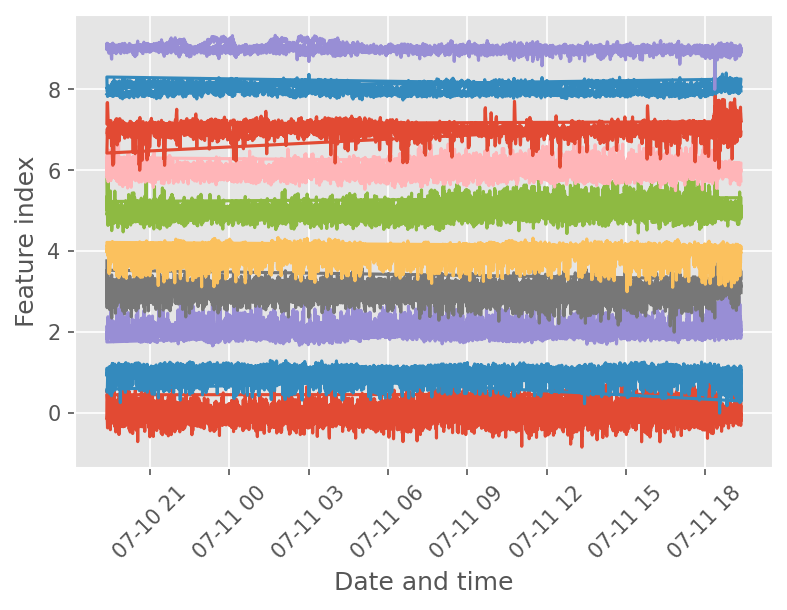

In [60]:
n_components=10
model = FastICA(n_components=n_components, whiten="unit-variance", random_state=123, max_iter=1000)
features = model.fit_transform(scattering_coefficients)

# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=150)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

plt.xticks(rotation=45) 
# Show
plt.show();

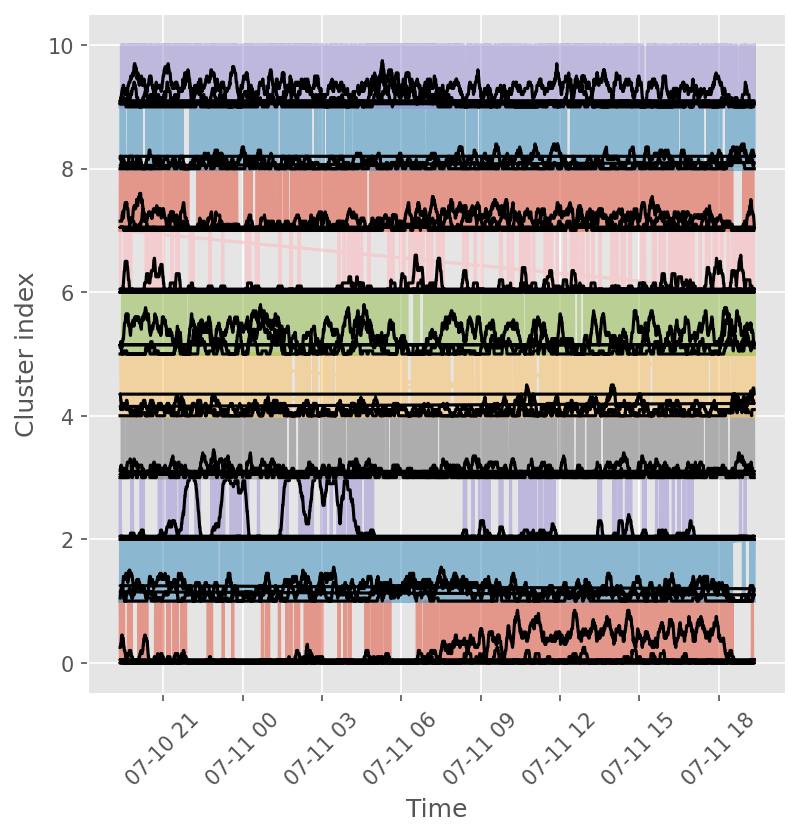

In [61]:
N_CLUSTERS = 10

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, init="k-means++", random_state=123)
model.fit(features)

# Predict cluster for each sample
predictions = model.predict(features)

SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")
plt.xticks(rotation=45) 
plt.show();

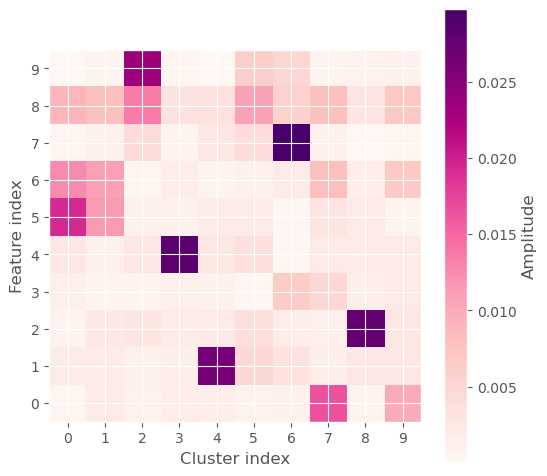

In [62]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show();

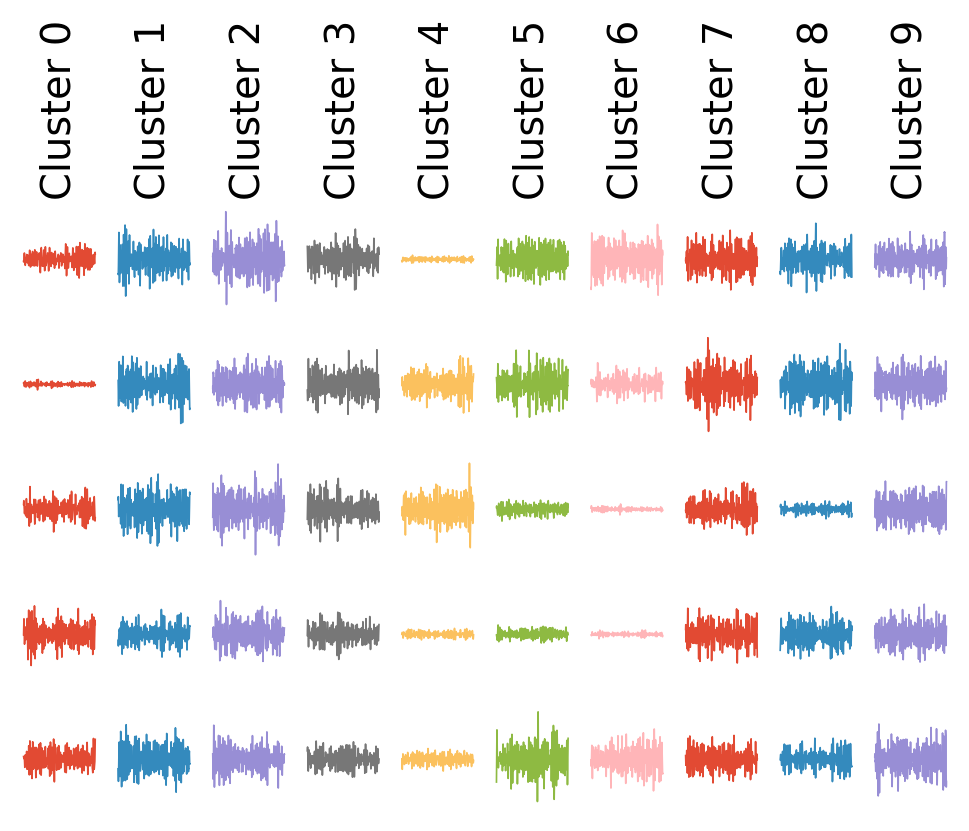

In [63]:
N_WAVEFORMS = 5

waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    
    # Convert boolean array to integer indices
    indices = np.where(predictions == cluster)[0]
    closest_indices = indices[distance.argsort()[:N_WAVEFORMS]]
    closest = [times[i] for i in closest_indices]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy() 
        traces.append(trace)
    waveforms.append(traces)

# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=200)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show();